In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import wget

In [2]:
#data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv'
#wget.download(data, 'AER_credit_card_data.csv')

'AER_credit_card_data (1).csv'

In [3]:
df = pd.read_csv('AER_credit_card_data.csv')
df.head().T

,0,1,2,3,4
card,yes,yes,yes,yes,yes
reports,0,0,0,0,0
age,37.66667,33.25,33.66667,30.5,32.16667
income,4.52,2.42,4.5,2.54,9.7867
share,0.03327,0.005217,0.004156,0.065214,0.067051
expenditure,124.9833,9.854167,15.0,137.8692,546.5033
owner,yes,no,yes,no,yes
selfemp,no,no,no,no,no
dependents,3,3,4,0,2
months,54,34,58,25,64


In [10]:
df.columns

Index(['card', 'reports', 'age', 'income', 'share', 'expenditure', 'owner',
       'selfemp', 'dependents', 'months', 'majorcards', 'active'],
      dtype='object')

In [4]:
df.card = (df.card == 'yes').astype(int)
df.card

0       1
1       1
2       1
3       1
4       1
       ..
1314    1
1315    0
1316    1
1317    1
1318    1
Name: card, Length: 1319, dtype: int32

In [13]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 1)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 1)
df_train.reset_index(drop = True, inplace = True)
df_val.reset_index(drop = True, inplace = True)
df_test.reset_index(drop = True, inplace = True)

y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

del df_train['card']
del df_val['card']
del df_test['card']

len(df_train), len(df_val), len(df_test)

(791, 264, 264)

## Question 1

- For each numerical variable, use it as score and compute AUC with the card variable.
- Use the training dataset for that.

Which numerical variable (among the following 4) has the highest AUC?
<br> Following variables : reports, dependents, active, share

**share**

In [14]:
numerical = ['reports', 'age', 'income', 'share', 'expenditure', 'dependents', 'months', 'majorcards', 'active']
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score


In [25]:
for i in numerical:
    auc = roc_auc_score(y_train, df_train[i])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[i])
    print('%9s, %.3f' % (i, auc))

  reports, 0.717
      age, 0.524
   income, 0.591
    share, 0.989
expenditure, 0.991
dependents, 0.533
   months, 0.529
majorcards, 0.534
   active, 0.604


In [26]:
cols_used = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

# Apply one hot encoding
from sklearn.feature_extraction import DictVectorizer
train_dicts = df_train[cols_used].to_dict(orient = 'records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[cols_used].to_dict(orient = 'records')
X_val = dv.transform(val_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

In [29]:
y_pred = model.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred).round(3)

0.995

## Question 3

Now let's compute precision and recall for our model.

- Evaluate the model on the validation dataset on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

At which threshold precision and recall curves intersect?

**0.3**

In [34]:
scores = []

tresholds = np.linspace(0, 1, 101)

for i in tresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= i)
    predict_negative = (y_pred < i)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((i, tp, fp, fn, tn))

columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,threshold,tp,fp,fn,tn
0,0.00,211,53,0,0
1,0.01,211,34,0,19
2,0.02,211,31,0,22
3,0.03,211,24,0,29
4,0.04,211,22,0,31
...,...,...,...,...,...
96,0.96,204,0,7,53
97,0.97,203,0,8,53
98,0.98,203,0,8,53
99,0.99,202,0,9,53


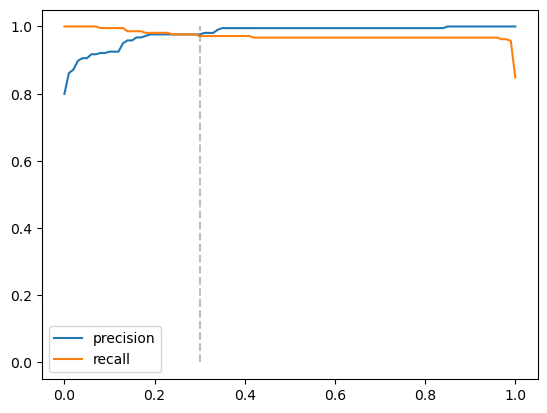

In [37]:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.vlines(0.3, 0, 1, color='grey', linestyle='--', alpha=0.5)

plt.legend()
plt.show()

## Question 4

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01 using the validation set

At which threshold F1 is maximal?

**0.4**

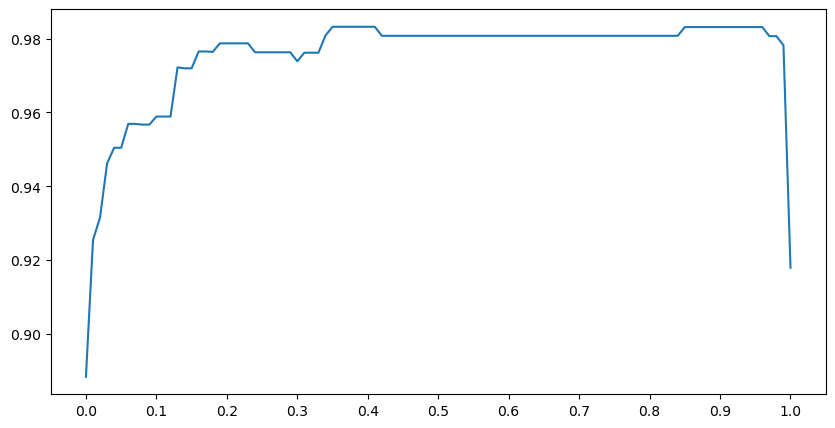

In [39]:
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)
plt.figure(figsize=(10, 5))

plt.plot(df_scores.threshold, df_scores.f1)

plt.xticks(np.linspace(0, 1, 11))
plt.show()

In [41]:
df_scores[df_scores.f1 == df_scores.f1.max()]

,threshold,tp,fp,fn,tn,p,r,f1
35,0.35,205,1,6,52,0.995146,0.971564,0.983213
36,0.36,205,1,6,52,0.995146,0.971564,0.983213
37,0.37,205,1,6,52,0.995146,0.971564,0.983213
38,0.38,205,1,6,52,0.995146,0.971564,0.983213
39,0.39,205,1,6,52,0.995146,0.971564,0.983213
40,0.40,205,1,6,52,0.995146,0.971564,0.983213
41,0.41,205,1,6,52,0.995146,0.971564,0.983213


## Question 5

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

`KFold(n_splits=5, shuffle=True, random_state=1)`

- Iterate over different folds of df_full_train
- Split the data into train and validation
- Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
- Use AUC to evaluate the model on validation

How large is standard devidation of the AUC scores across different folds?

**0.003**

In [46]:
from sklearn.model_selection import KFold


In [45]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    y_train = df_train.card.values
    y_val = df_val.card.values

    train_dicts = df_train[cols_used].to_dict(orient = 'records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    val_dicts = df_val[cols_used].to_dict(orient = 'records')
    X_val = dv.transform(val_dicts)

    y_pred = model.predict_proba(X_val)[:, 1]

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.996 +- 0.003


## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

- Iterate over the following C values: [0.01, 0.1, 1, 10]
- Initialize KFold with the same parameters as previously
- Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

**10**

In [49]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.01, 0.1, 1, 10]:

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        y_train = df_train.card.values
        y_val = df_val.card.values

        train_dicts = df_train[cols_used].to_dict(orient = 'records')
        dv = DictVectorizer(sparse=False)
        X_train = dv.fit_transform(train_dicts)

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)

        val_dicts = df_val[cols_used].to_dict(orient = 'records')
        X_val = dv.transform(val_dicts)

        y_pred = model.predict_proba(X_val)[:, 1]

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%4s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.01, 0.992 +- 0.006
C= 0.1, 0.993 +- 0.005
C=   1, 0.994 +- 0.005
C=  10, 0.995 +- 0.004
